This code reads in the Deep Learning network created by running on nutau and nue samples from Dasha.
It is supposed to then create heat maps but I haven't been able to finish that.

This code runs in a python 3.7 conda environment constructed as follows:
- conda create --name tf-gpu tensorflow-gpu keras scikit-learn matplotlib ipykernel nb_conda_kernels [Pillow]
- conda activate tf-gpu
(Pillow is for image manipulation for making heat maps, but I haven't got it to work yet.)

In [4]:
from __future__ import division
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import rgb_to_hsv
import numpy as np
import pickle
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K

In [5]:
#Load model
model_1 = load_model('/home/dup193/work/double_pulse/AC922/vgg16_200k_Qst_2000_2/vgg16_200k_QSt2000_dataset_norm_2.h5')
model_2 = load_model('/home/dup193/work/double_pulse/AC922/vgg16_700k_Qst_2000_MuvsTau_3/vgg16_700k_QSt2000_dataset_norm_MuVsTau_3.h5')
#mo
model_1.summary()
model_2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 500, 60, 1)] 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 500, 60, 1)] 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 500, 60, 1)] 0                                            
__________________________________________________________________________________________________
convolutional_layers (Sequentia (None, 7680)         14713536    input_1[0][0]                    
                                                                 input_2[0][0]                

In [16]:
data_t = np.load('/home/dup193/work/double_pulse/data/images_3str/Images_NuTau_1_1_3_data.npz',mmap_mode='r')['arr_0']

In [20]:
def check(data):
    #data = np.load(file_name, mmap_mode="r")['arr_0']
    fig = plt.figure(figsize=(15, 5))
    ax1 = fig.add_subplot(131)
    ax1.imshow(data['image'][0,:,:,0], interpolation='nearest', aspect='auto', cmap= 'gray')
    ax2 = fig.add_subplot(132)
    ax2.imshow(data['image'][0,:,:,1], interpolation='nearest', aspect='auto', cmap= 'gray')
    ax3 = fig.add_subplot(133)
    ax3.imshow(data['image'][0,:,:,2], interpolation='nearest', aspect='auto', cmap= 'gray')

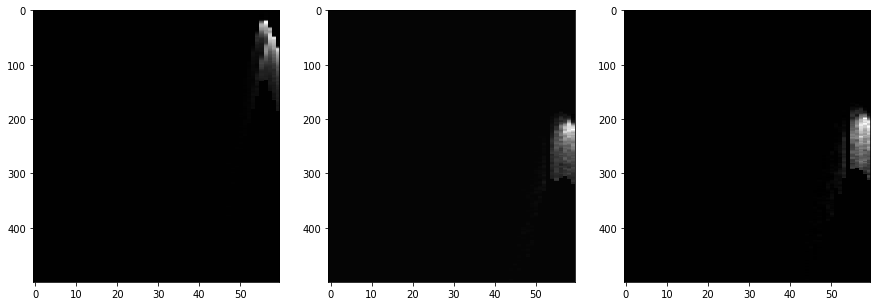

In [40]:
check(data_t[30])

In [68]:
tensors = []
decision = []
mean = 0.0012322452384978533 
std = 0.009694634936749935
#for i in range(30,31):
im = data_t[30]['image']
im = (im-mean)/std
tensors.append(im)
print(im[:,:,:,:1].shape)
pred_n1 = model_1.predict([im[:,:,:,:1],im[:,:,:,1:2],im[:,:,:,2:3]],batch_size =1)
print(pred_n1)

(1, 500, 60, 1)
[[0.9999522]]


In [76]:
model_1.layers[3].summary()

Model: "convolutional_layers"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 502, 62, 1)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 500, 60, 64)       640       
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 502, 62, 64)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 500, 60, 64)       36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 250, 30, 64)       0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 252, 32, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 250, 30, 1

In [69]:
def MakeHeatmap(tensor, model, layer):
    
    double_pulse_output = model.output[:, 0]
    last_conv_layer = model.get_layer(layer)
    grads = K.gradients(double_pulse_output, last_conv_layer.output)[0]
    print(grads)
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    print(pooled_grads)
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

    pooled_grads_value, conv_layer_output_value = iterate([tensor])

    for i in range(128):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

    heatmap = np.mean(conv_layer_output_value, axis=-1)
    scale = max(heatmap.min(), heatmap.max(), key=abs)
    heatmap = heatmap / scale 
    #heatmap[heatmap<0] = 0
    
    return heatmap    

In [70]:
def Overlay(tensor, heatmap):
    img = tensor.reshape(tensor.shape[1],tensor.shape[2])
    img_max = np.max(img)
    #img[img<0] = 0
    img = img / img_max /1.1+ 0.04
    img = 1 - img
    
    htm = cv2.resize(heatmap, (img.shape[1], img.shape[0]),interpolation = cv2.INTER_NEAREST)
    cm = plt.get_cmap('inferno')
    htm = cm(htm)
    htm[:,:,3] = img
    #htm = htm[:,:,:3]
    #print(htm[:10])
  
    #hsv = mpl.colors.rgb_to_hsv(htm)
    #print(hsv[:10])
    #for i, row in enumerate(img):
    #    for j, val in enumerate(row):
    #        htm[i][j][1] = val
            
    return(htm)

In [80]:
grad_model = tf.keras.models.Model(
        [model_1.inputs], [model_1.get_layer('max_pooling2d_4'),get_layer('max_pooling2d_4').output, model.output]
    )


ValueError: No such layer: max_pooling2d_4